In [1]:
import sys
sys.path.append('../')
from data_access.data_access_utility import ABRDataAccess
from classifier.classical_classifiers import SVM, RFClassifier, KNN

In [125]:
feature_list=['snps_nonsyn_trimmed','phylogenetic','continous_mic_vals']
ABRAccess=ABRDataAccess('/mounts/data/proj/asgari/dissertation/datasets/deepbio/pseudomonas/data_v3/',feature_list)
X,Y,features, iso=ABRAccess.get_xy_multidrug_prediction_mats()
temp=X[:,5::].toarray()
Y=X[:,0:5].toarray()
X=temp
labels_list=features[0:5]
features=features[5::]

Data access created..
@@@/mounts/data/proj/asgari/dissertation/datasets/deepbio/pseudomonas/data_v3/snps_nonsyn_trimmed_feature_vect.npz
@@@/mounts/data/proj/asgari/dissertation/datasets/deepbio/pseudomonas/data_v3/phylogenetic_feature_vect.npz
@@@/mounts/data/proj/asgari/dissertation/datasets/deepbio/pseudomonas/data_v3/continous_mic_vals_feature_vect.npz


In [196]:

import sys
sys.path.append('../')

import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from utility.file_utility import FileUtility
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
from gensim.models.wrappers import FastText
import itertools
import os
import matplotlib.pyplot as plt
import matplotlib


class DNNAMR(object):
    
    def __init__(self, X,Y, model_arch=[500]):
        # rep. X
        self.X=X
        # encoding Y
        self.C=Y.shape[1]
        self.Y=Y
        # model's arch
        self.model_arch=model_arch
    
    def get_MLP_model(self):
        # creating the model
        model = Sequential()
        for layer_idx, h_layer_size in enumerate(self.model_arch):
            if layer_idx==0:
                model.add(Dense(h_layer_size, input_dim=self.X.shape[1], activation='relu'))
            else:
                if h_layer_size < 1:
                    model.add(Dropout(h_layer_size))
                else:
                    model.add(Dense(h_layer_size, activation='relu'))
        model.add(Dense(self.C,activation='relu'))
        # Compile model
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
        return model
    
    
    def cross_validation(self, result_filename, gpu_dev='3', n_fold=5, epochs=100, batch_size=5, model_strct='mlp', pretrained_model=False, trainable=False):

        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_dev
        
        skf = KFold(n_splits=n_fold, shuffle=True)
        
        for train_index, valid_index in skf.split(self.X, self.Y):
            print ('\n Evaluation on a new fold is now get started ..')
            X_train=self.X[train_index,:]
            y_train=self.Y[train_index,:]
            X_valid=self.X[valid_index,:]
            y_valid=self.Y[valid_index,:]
            
            if pretrained_model:
                model=self.get_pretrained_model(model_strct, trainable)
            else:
                if model_strct=='mlp':
                    model=self.get_MLP_model()
                if model_strct=='embmlp':
                    model=self.get_EMB_MLP_model()
            
            # fitting
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,shuffle=True, validation_data=(X_valid, y_valid), verbose=0)
            
        self.history=history
        self.model=model
        
        
        history_dict = history.history
        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        epochs = range(1, len(loss_values) + 1)

        if pretrained_model:
            model_strct='pretrained'
            #print (model.summary())
        
        weights=[]
        for x in model.layers:
            weights.append(x.get_weights())
        
        FileUtility.save_obj('_'.join([result_filename, 'layers', model_strct,'-'.join([str(x) for x in self.model_arch])]), (weights,(loss_values, val_loss_values, epochs)))

    @staticmethod
    def load_history(filename, fileout):
        [latex_line, p_micro, r_micro, f1_micro, p_macro, r_macro, f1_macro, history]=FileUtility.load_obj(filename)
        (loss_values, val_loss_values, epochs)=history
        matplotlib.rcParams['mathtext.fontset'] = 'stix'
        matplotlib.rcParams['font.family'] = 'STIXGeneral'
        matplotlib.rcParams['mathtext.fontset'] = 'custom'
        matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
        matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
        matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
        matplotlib.rcParams["axes.edgecolor"] = "black"
        matplotlib.rcParams["axes.linewidth"] = 0.6
        plt.rc('text', usetex=True)
        plt.plot(epochs, loss_values, 'ro', label='Loss for train set')
        plt.plot(epochs, val_loss_values, 'b+', label='Loss for test set')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc=1, prop={'size': 8},ncol=1, edgecolor='black', facecolor='white', frameon=True)
        plt.title('Loss with respect to the number of epochs for train and test sets')
        plt.savefig(fileout+'.pdf')
        plt.show()
        
        
    @staticmethod
    def make_activation_function(file_name, X, last_layer=None):
        pretrained_weights=FileUtility.load_obj(file_name)
        if last_layer:
            h_sizes=[float(x) for x in file_name.split('/')[-1].split('_')[3].split('-')]+[last_layer]
        else:
            h_sizes=[float(x) for x in file_name.split('/')[-1].split('_')[3].split('-')]
        model = Sequential()
        for layer_idx, h_layer_size in enumerate(h_sizes):
            if layer_idx==0:
                model.add(Dense(int(h_layer_size), input_dim=X.shape[1], weights=pretrained_weights[0],  activation='relu'))
            else:
                if h_layer_size < 1:
                    model.add(Dropout(h_layer_size, weights=pretrained_weights[layer_idx]))
                else:
                    if layer_idx == len(h_sizes)-1 and last_layer:
                        model.add(Dense(int(h_layer_size), weights=pretrained_weights[layer_idx], activation='sigmoid'))
                    else:
                        model.add(Dense(int(h_layer_size), weights=pretrained_weights[layer_idx], activation='relu'))
        activations = model.predict(X)
        np.savetxt(file_name.replace(file_name.split('/')[-1].split('_')[0],'activationlayer'),activations)
        return activations

In [216]:
DNN=DNNAMR(X,Y*100,model_arch=[1000,0.2,500,0.1,500])

In [ ]:
DNN.cross_validation('../results/classification/dnn/', gpu_dev='3', n_fold=3, epochs=300, batch_size=5, model_strct='mlp')


 Evaluation on a new fold is now get started ..


In [218]:
history=DNN.history
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

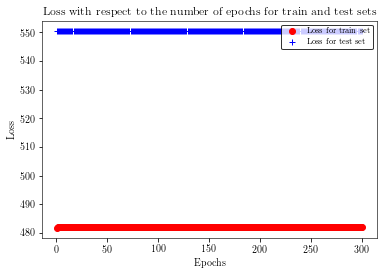

In [219]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["axes.linewidth"] = 0.6
plt.rc('text', usetex=True)
plt.plot(epochs, loss_values, 'ro', label='Loss for train set')
plt.plot(epochs, val_loss_values, 'b+', label='Loss for test set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=1, prop={'size': 8},ncol=1, edgecolor='black', facecolor='white', frameon=True)
plt.title('Loss with respect to the number of epochs for train and test sets')
plt.show()
        

In [220]:
Y_hat=DNN.model.predict_on_batch(X[1:6,:])

In [221]:
X[1:6,:]

array([[ 0.        ,  0.        ,  0.        , ...,  0.01805095,
        -0.00303337,  0.00430073],
       [ 1.        ,  0.        ,  0.        , ..., -0.01002263,
         0.01075347, -0.01498816],
       [ 0.        ,  0.        ,  0.        , ...,  0.01681682,
        -0.01322764,  0.02109493],
       [ 0.        ,  0.        ,  0.        , ...,  0.01847024,
        -0.01287623,  0.02317673],
       [ 0.        ,  0.        ,  1.        , ...,  0.01630178,
        -0.00991178,  0.02462367]])

In [222]:
np.max(Y_hat)

0.0

In [223]:
Y_hat

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]], dtype=float32)